# 1. データの取得  
ダウンロードしたipynbファイルとcsvファイルを自分のGoogleドライブに置く。

In [ ]:
# Google-ColaboratoryからGoogleドライブにアクセスするためのおまじない。

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# csvファイルをダウンロード
import pandas as pd

df = pd.read_csv('drive/My Drive/USDJPY.csv')
df

,DateTime,Open,High,Low,Close,Volume
0,2005-05-07T21:00:00.000000000Z,105.145,105.165,105.075,105.125,254
1,2005-05-08T21:00:00.000000000Z,105.135,105.686,105.095,105.628,34018
2,2005-05-09T21:00:00.000000000Z,105.628,105.966,105.390,105.560,34363
3,2005-05-10T21:00:00.000000000Z,105.550,105.946,104.886,105.760,36765
4,2005-05-11T21:00:00.000000000Z,105.760,106.914,105.710,106.776,32469
...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,114.650,115.489,114.476,115.362,85666
4996,2022-01-27T22:00:00.000000000Z,115.358,115.688,115.122,115.238,73707
4997,2022-01-30T22:00:00.000000000Z,115.296,115.592,114.923,115.136,70090
4998,2022-01-31T22:00:00.000000000Z,115.110,115.195,114.566,114.688,68569


# 2. データの加工
終値と流通量に追加で、ボラティリティと指数移動平均値を用いる。

In [ ]:
def processing_df(df):
  # 日時と時間のcolumnsを追加する
  df['close'] = df['Close']
  df['ema_close'] = df['close'].ewm(span=5).mean()
  df['aoc_close'] = df['close'].diff(1)
  df['aoc_close'] = df['aoc_close'].fillna(df['aoc_close'].median())
  ewdf = df['aoc_close'].ewm(halflife=5).mean()
  vewdf = df['aoc_close'].ewm(halflife=5).var()
  df['ewdf_aoc_close'] = (df['aoc_close'] - ewdf)/(vewdf ** 0.5)
  df['ewdf_aoc_close'] = df['ewdf_aoc_close'].fillna(df['ewdf_aoc_close'].median())

  # voratilityはノイズが多いので、ここでスケーリングする。
  df['volatility'] = df['High'] - df['Low']
  ewdf = df['volatility'].ewm(halflife=5).mean()
  vewdf = df['volatility'].ewm(halflife=5).var()
  df['ewdf_volatility'] = (df['volatility'] - ewdf)/(vewdf ** 0.5)
  df['ewdf_volatility'] = df['ewdf_volatility'].fillna(df['ewdf_volatility'].median())

  df['volume'] = df['Volume']
  

  # columnsの位置を変更する
  df = df[['DateTime', 'close', 'ema_close', 'aoc_close', 'ewdf_aoc_close', 'volatility', 'ewdf_volatility', 'volume']]
  return df

processing_df = processing_df(df)
processing_df

,DateTime,close,ema_close,aoc_close,ewdf_aoc_close,volatility,ewdf_volatility,volume
0,2005-05-07T21:00:00.000000000Z,105.125,105.125000,0.000,-0.013379,0.090,-0.092556,254
1,2005-05-08T21:00:00.000000000Z,105.628,105.426800,0.503,0.658172,0.591,0.658172,34018
2,2005-05-09T21:00:00.000000000Z,105.560,105.489895,-0.068,-0.662495,0.576,0.492414,34363
3,2005-05-10T21:00:00.000000000Z,105.760,105.602092,0.200,0.164992,1.060,1.091854,36765
4,2005-05-11T21:00:00.000000000Z,106.776,106.052739,1.016,1.350086,1.204,0.981569,32469
...,...,...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,115.362,114.614911,0.681,1.215709,1.013,1.454070,85666
4996,2022-01-27T22:00:00.000000000Z,115.238,114.822607,-0.124,-0.486597,0.566,-0.457180,73707
4997,2022-01-30T22:00:00.000000000Z,115.136,114.927071,-0.102,-0.401881,0.669,0.015756,70090
4998,2022-01-31T22:00:00.000000000Z,114.688,114.847381,-0.448,-1.048126,0.629,-0.169012,68569


# 3. データを可視化  
上から、'終値'、'終値のEMA', '終値の変化量', '終値の変化量のEWDF'をプロット。  
特に、'終値'と'終値の5日移動平均値'、 'ボラティリティ'と 'ボラティリティのEWDF'をそれぞれ比較して何のために、EMA、EWDFを求めたのかを考えてもらいたい。

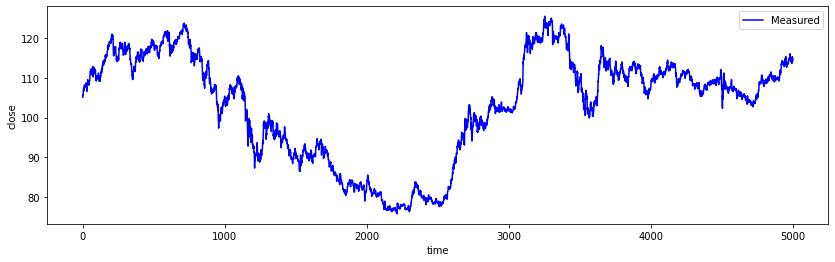

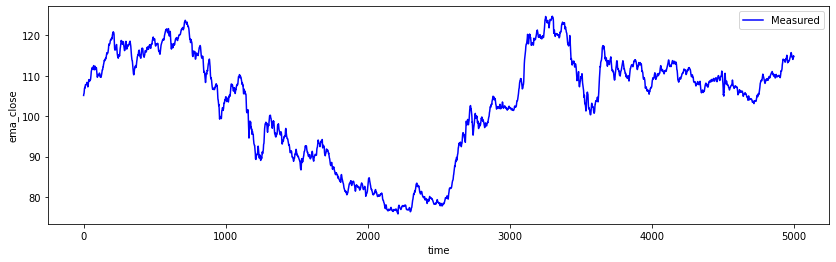

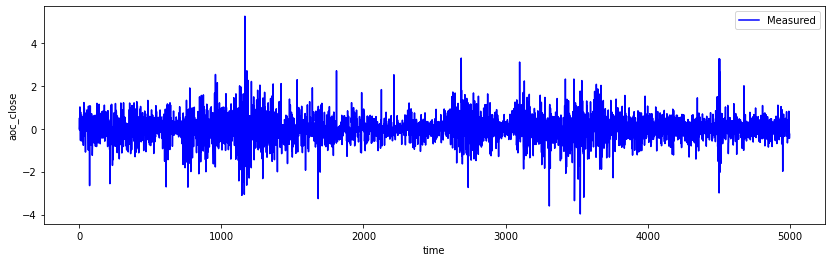

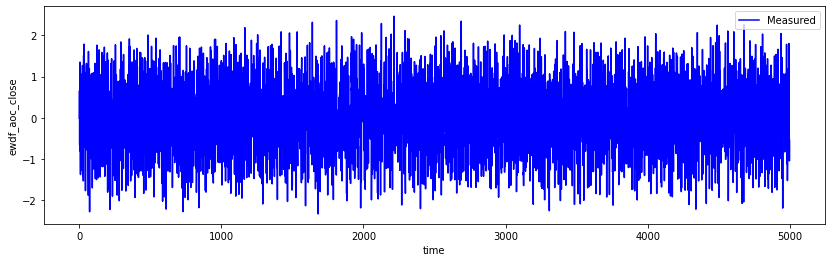

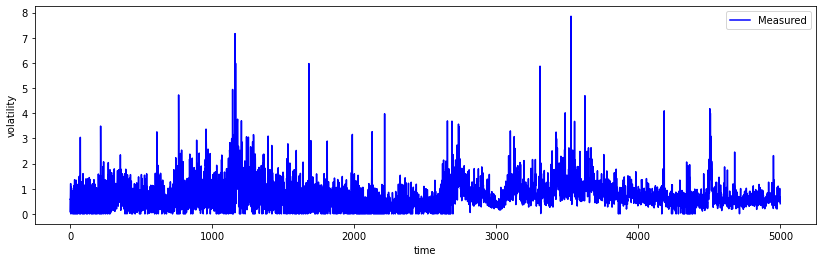

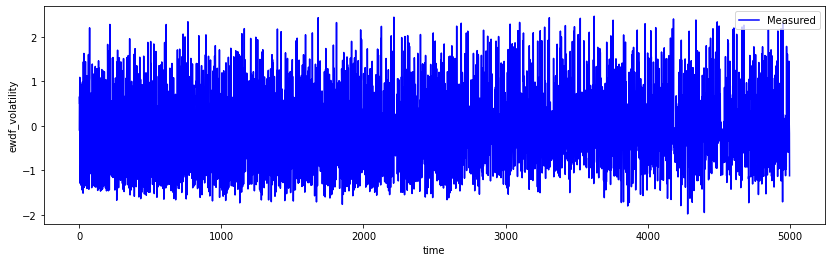

In [ ]:
import matplotlib.pyplot as plt

def show_graph_norm(df, data ,label='close', color="b"):
  X_index = df.index.values
  X_open = data.values
  plt.figure(figsize=(14, 4))
  plt.xlabel('time')
  plt.ylabel(label)
  plt.plot(X_index, X_open, color=color, label='Measured')
  plt.legend(loc='upper right')
  plt.show()

show_graph_norm(processing_df, processing_df['close'])
show_graph_norm(processing_df, processing_df['ema_close'], 'ema_close')
show_graph_norm(processing_df, processing_df['aoc_close'], 'aoc_close')
show_graph_norm(processing_df, processing_df['ewdf_aoc_close'], 'ewdf_aoc_close')
show_graph_norm(processing_df, processing_df['volatility'], 'volatility')
show_graph_norm(processing_df, processing_df['ewdf_volatility'], 'ewdf_volatility')

# 4. スケーリング
前回は正規化を用いたが、**先読み**を避けるために今回は手動でスケーリングする。

In [ ]:
# 正規化のためのライブラリ。
from sklearn.preprocessing import MinMaxScaler

def Normalization(data):
  data = pd.DataFrame(data)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  data = scaler.fit_transform(data)
  return scaler, data

scaler, data = Normalization(df['ewdf_aoc_close'])

In [ ]:
def Discaled(data):
  data = data.to_numpy().reshape(len(df), -1)
  return data

data = Discaled(df['ewdf_aoc_close'])

# 5. 訓練データと検証データとテストデータに分割  
モデルの精度を検証するためにはデータを**訓練データ**と**テストデータ**に分割する必要がある。

In [ ]:
# 70%で訓練、20%で検証、10%でテストする。

def split_train_valid_test(data):
  train, valid, test = data[0:int(len(data)*0.7),:], data[int(len(data)*0.7):int(len(data)*0.9),:], data[int(len(data)*0.9):,:]
  return train, valid, test

train, valid, test = split_train_valid_test(data)

# 6. モデルの検証

In [ ]:
# 必要なライブラリをインポート。
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# モデル学習のためのライブラリ
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense

In [ ]:
# モデルの学習のためのパラメータを指定。

# ルックバック
# 過去どれくらいまで遡るかの指標。
# look_back=50の場合は現時点をtを予測するために[t-50, t-49, ... , t-1]までを用いる。
look_back=50

# エポックサイズ
# モデルの学習回数。
epoch_size = 30

# バッチサイズ
# モデルが1回の処理で使用する件数。
# 一般にbatch_sizeが大きい方が、計算速度が速くなる一方、精度は低下する。
batch_size=1

In [ ]:
# 入出力用データセットに変換。

def create_dataset(dataset):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    xset = []
    for j in range(dataset.shape[1]):
      # 0～10, 1～11, 2～12, …と10個づつ格納される
      a = dataset[i:(i+look_back), j]
      xset.append(a)
    # datasetのうち、11個目～11+56個目までを格納
    dataY.append(dataset[i + look_back, 0])      
    dataX.append(xset)
  return np.array(dataX), np.array(dataY)

In [ ]:
# モデルの作成。

def create_model(epoch_size, look_back):
    model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=(1, look_back)), # 引数の数
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model(epoch_size, look_back)

In [ ]:
# モデルの学習
# 使用するPCによって5分以上かかりますが、我慢してください。
# GPUを使用すれば少し早くなります。ランタイム→ランタイプの変更→GPUで変更可能。

def learning_model(train, valid):
  trainX, trainY = create_dataset(train)
  validX, validY = create_dataset(valid)
  history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY), batch_size=batch_size, verbose=2)
  return trainX, trainY, validX, validY, history

trainX, trainY, validX, validY, history = learning_model(train, valid)

Epoch 1/30
3449/3449 - 13s - loss: 0.6927 - val_loss: 0.7080 - 13s/epoch - 4ms/step
Epoch 2/30
3449/3449 - 10s - loss: 0.6562 - val_loss: 0.7206 - 10s/epoch - 3ms/step
Epoch 3/30
3449/3449 - 10s - loss: 0.6154 - val_loss: 0.7367 - 10s/epoch - 3ms/step
Epoch 4/30
3449/3449 - 10s - loss: 0.5623 - val_loss: 0.7842 - 10s/epoch - 3ms/step
Epoch 5/30
3449/3449 - 10s - loss: 0.5098 - val_loss: 0.8506 - 10s/epoch - 3ms/step
Epoch 6/30
3449/3449 - 10s - loss: 0.4627 - val_loss: 0.8926 - 10s/epoch - 3ms/step
Epoch 7/30
3449/3449 - 10s - loss: 0.4172 - val_loss: 0.9492 - 10s/epoch - 3ms/step
Epoch 8/30
3449/3449 - 10s - loss: 0.3731 - val_loss: 0.9803 - 10s/epoch - 3ms/step
Epoch 9/30
3449/3449 - 10s - loss: 0.3374 - val_loss: 1.0374 - 10s/epoch - 3ms/step
Epoch 10/30
3449/3449 - 10s - loss: 0.3069 - val_loss: 1.0548 - 10s/epoch - 3ms/step
Epoch 11/30
3449/3449 - 10s - loss: 0.2784 - val_loss: 1.1704 - 10s/epoch - 3ms/step
Epoch 12/30
3449/3449 - 10s - loss: 0.2509 - val_loss: 1.1933 - 10s/epoch 

# 7. モデルの性能評価

In [ ]:
import math
from sklearn.metrics import mean_squared_error

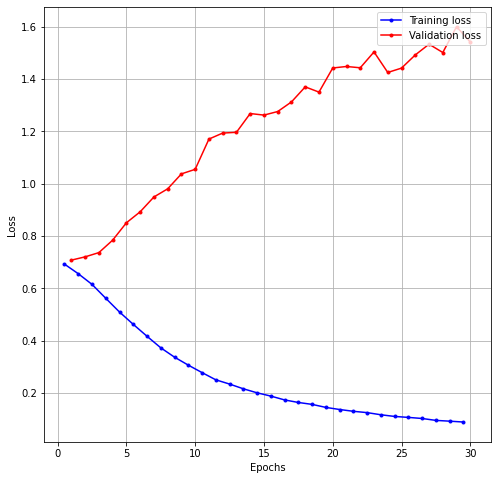

In [ ]:
# 各エポック毎の訓練誤差とテスト誤差を可視化。この結果はさすがにダメすぎる。訓練誤差が発散している。しいて言うならば、エポックサイズ14回が一番いい。

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [ ]:
def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset

def print_mse(model, trainX, trainY, validX, validY, test, scaler=False):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testX, testY = create_dataset(test)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)

    # 標準化したデータを元に戻す
    if scaler == True:
      trainPredict = scaler.inverse_transform(pad_array(trainPredict, pad_col))
      trainY = scaler.inverse_transform(pad_array(trainY, pad_col))
      validPredict = scaler.inverse_transform(pad_array(validPredict, pad_col))
      validY = scaler.inverse_transform(pad_array(validY, pad_col))
      testPredict = scaler.inverse_transform(pad_array(testPredict, pad_col))
      testY = scaler.inverse_transform(pad_array(testY, pad_col))
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, test)

Train Score: 0.25 RMSE
Valid Score: 1.24 RMSE
Test Score: 1.25 RMSE


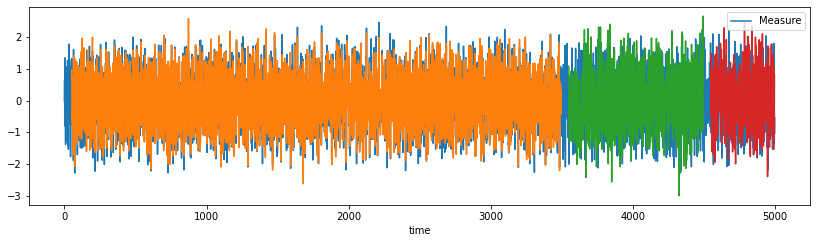

In [ ]:
def train_predictions_for_plotting(data, look_back, trainPredict, validPredict, testPredict, scaler=False):
    # trainPredict
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    train_start_index = look_back
    train_end_index = len(trainPredict) + look_back
    trainPredictPlot[train_start_index:train_end_index, :] = trainPredict

    # validPredict
    validPredictPlot = np.empty_like(data)
    validPredictPlot[:, :] = np.nan
    valid_start_index = train_end_index + look_back + 1
    valid_end_index = valid_start_index + len(validPredict)
    validPredictPlot[valid_start_index:valid_end_index, :] = validPredict

    # testPredict
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    test_start_index = valid_end_index + look_back + 1
    test_end_index = test_start_index + len(testPredict)
    testPredictPlot[test_start_index:test_end_index, :] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    if scaler == True:
      plt.plot(scaler.inverse_transform(data), label='Measure')
    else:
      plt.plot(data, label='Measure')
    plt.plot(trainPredictPlot)
    plt.plot(validPredictPlot)
    plt.plot(testPredictPlot)
    plt.legend(loc='upper right')
    plt.xlabel('time')
    plt.show()
    return trainPredictPlot, validPredictPlot

trainPredictPlot, testPredictPlot = train_predictions_for_plotting(data, look_back, trainPredict, validPredict, testPredict)